In [1]:
using AlgebraicPetri, DataFrames, DifferentialEquations, ModelingToolkit, Symbolics,
      EasyModelAnalysis, Catlab, Catlab.CategoricalAlgebra, JSON3, UnPack, CSV, DataFrames,
      Downloads, URIs, CSV, DataFrames, MathML, NLopt

In [20]:
include("demo_functions.jl")

train_test_split

1. Upload a ground-truth dataset and its documentation via a URL
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/truth-Incident%20Hospitalizations.csv
    * https://github.com/reichlab/covid19-forecast-hub/blob/master/data-truth/README.md 

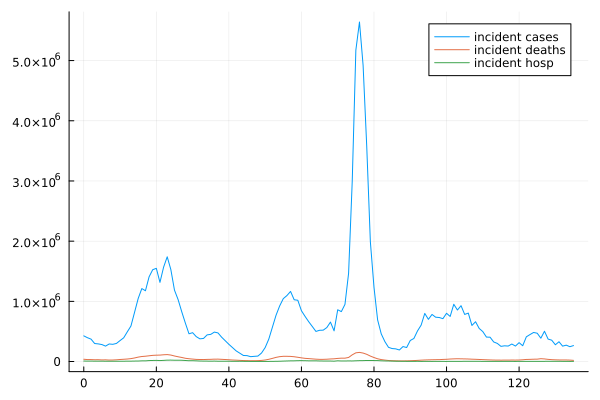

In [3]:
urls = [
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Cases.csv",
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Deaths.csv",
    "https://github.com/reichlab/covid19-forecast-hub/raw/master/data-truth/truth-Incident%20Hospitalizations.csv",
]

filenames = [joinpath(@__DIR__, "../data/", URIs.unescapeuri(split(url, "/")[end]))
             for url in urls]
download_covidhub_data(urls, filenames)

# Read the local CSV files into DataFrames
dfc = CSV.read(filenames[1], DataFrame)
dfd = CSV.read(filenames[2], DataFrame)
dfh = CSV.read(filenames[3], DataFrame)
covidhub = calibration_data(dfc, dfh, dfd, use_hosp = true)
df = groupby_week(covidhub)
plot_covidhub(df)

2. Split the dataset into a list of sub-datasets covering time periods of interest (in weeks)
    * select_timeperiods(df::DataFrame)::Vector{DataFrame}}


In [13]:
dfs = select_timeperiods(df, 10)

13-element Vector{DataFrame}:
 10×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228
   6 │     5  281799   26604   5821
   7 │     6  256026   28030   5071
   8 │     7  291617   24191   5275
   9 │     8  286018   25358   5347
  10 │     9  300436   28491   4953
 10×4 DataFrame
 Row │ t      cases    deaths  hosp  
     │ Int64  Int64    Int64   Int64 
─────┼───────────────────────────────
   1 │    10   348113   33744   5113
   2 │    11   394038   37562   5144
   3 │    12   493557   41729   5863
   4 │    13   589923   48331   6133
   5 │    14   818658   59224   7558
   6 │    15  1048060   73406   8317
   7 │    16  1212395   83419  11241
   8 │    17  1175780   88260  11034
   9 │    18  1406989   95431  16127
  10 │    19  152555

### Loading the Petri nets for our ensemble and converting them to ODESystems

In [7]:
petri_fns = [
    "BIOMD0000000955_miranet.json",
    "BIOMD0000000960_miranet.json",
    "BIOMD0000000983_miranet.json",
]

abs_fns = [joinpath(@__DIR__, "../data/", fn) for fn in petri_fns]
T_PLRN = PropertyLabelledReactionNet{Number, Number, Dict}

petris = read_json_acset.((T_PLRN,), abs_fns)
syss = structural_simplify.(ODESystem.(petris))
defs = map(x -> ModelingToolkit.defaults(x), syss)

3-element Vector{Dict{Any, Any}}:
 Dict(t5 => 0.171, zeta => 0.125, rho => 0.034, eta => 0.125, gamma => 0.456, t10 => 0.371, t16 => 0.017, Hospitalizations(t) => 0.0, Cases(t) => 0.0, Susceptible(t) => 0.9999963…)
 Dict(t5 => 0.053, ModelValue_13 => 0.053, Exposed(t) => 36600.0, ModelValue_17 => 1.64, t2 => 0.1, t3 => 0.1, ModelValue_135 => 328200000, Asymptomatic(t) => 2196.0, Infectious(t) => 732.0, beta_1_USA => 0.303…)
 Dict(t5 => 0.1, sigma => 0.2, Exposed(t) => 112.0, Quarantined(t) => 36.0, t2 => 0.1, t3 => 0.1, Susceptible_unconfined(t) => 6.699e7, q => 0.83, t7 => 0.1, t8 => 0.1…)

### Adjust all model defaults to be standardized to population, not proportion of population, then convert to simulatable ODEProblems

In [8]:
total_pop = 300_000_000
N_weeks = 10

# adjust the defaults to be in terms of the total population. now all 3 models have defaults in terms of pop
# this is a weak link in the workflow
for i in 1:2 # only the first two are in proportions 
    for st in states(syss[i])
        defs[i][st] *= total_pop # this mutates the return of ModelingToolkit.defaults
    end
end

probs = map(x -> ODEProblem(x, [], (0, 100)), syss); # goes after defaults canonicalization

3. Generate model-model and model-dataset alignment/map during structural comparisons
    * e.g. {("model0.S", "model1.s", ...):  "dataset.feature0", ...} 
    * V{Tuple{V{State/Obs}, Symbol}}. Hosp, cases, 


Since the MiraNet schema encodes the observables (Cases, Deaths, Hospitalizations) uniformly through all models in the ensemble, we only need to provide a single list of Model observable => column name

In [9]:
@unpack Deaths, Hospitalizations, Cases = syss[1]
mapping = Dict([Deaths => :deaths, Cases => :cases, Hospitalizations => :hosp])

Dict{Num, Symbol} with 3 entries:
  Deaths(t)           => :deaths
  Hospitalizations(t) => :hosp
  Cases(t)            => :cases

4. Build an ensemble model using a list of the above models and alignment/map.
    * build_ensemble_model(Tuple{Vector<ODESystem>, typeof(3)})::EnsembleProblem | Vector{ODEProblem}


In [10]:
probs = map(x -> ODEProblem(x, [], (0, 100)), syss);

5. Build and run an ensemble calibration simulator 
    * Select the list of split ground-truth sub-datasets as training-test datasets
    * Select the ensemble model as the input model
    * Select the alignment/map
    * Specify the ensemble calibration mode (no-training-equal-weights, separate-model-weight training, joint model-weight training)
    * Specify the train-validate-test ratio, cross-validation mode, loss function, early-stop condition, etc.
    * ensemble_calibrate_separate(typeof(4), typeof(2)[1][1]; optimization_options)::V<(calibrationmap,loss,weights)>
    * Total 1-4. train 1-2, test 3-4. Trainloss = l2(1-2), testloss = l2(3-4)  


In [26]:
split_dfs = [train_test_split(df; train_weeks=5) for df in dfs]
dfi = dfs[1]
dfx, dfy = split_dfs[1]

(5×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     0  426504   38039   7823
   2 │     1  396061   32638   7369
   3 │     2  372155   32164   7097
   4 │     3  299096   29605   6046
   5 │     4  292841   30061   6228, 5×4 DataFrame
 Row │ t      cases   deaths  hosp  
     │ Int64  Int64   Int64   Int64 
─────┼──────────────────────────────
   1 │     5  281799   26604   5821
   2 │     6  256026   28030   5071
   3 │     7  291617   24191   5275
   4 │     8  286018   25358   5347
   5 │     9  300436   28491   4953)

In [ ]:
ensemble_res = [calibrate(prob, dfx, mapping) for prob in probs]

### The next cell indicates that the third model is the best fit

In [24]:
new_probs = [remake(prob, u0 = res.u, p = res.u) for (prob, res) in zip(probs, ensemble_res)]

# push!(calibrated_probs, new_probs)
train_scores = EasyModelAnalysis.model_forecast_score(new_probs, dfx.t, to_data(dfx, mapping))
test_scores = EasyModelAnalysis.model_forecast_score(new_probs, dfy.t, to_data(dfy, mapping))
@info "Train scores: $(train_scores)"
@info "Test scores: $(test_scores)"



┌ Info: Train scores: [2.1325280346294276e7, 1.3564373828463439e7, 896280.7860142721]
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:6
┌ Info: Test scores: [2.101079964372161e7, 1.3400365807993922e7, 705386.6277568176]
└ @ Main /Users/anand/.julia/dev/EasyModelAnalysis/test/demo.ipynb:7


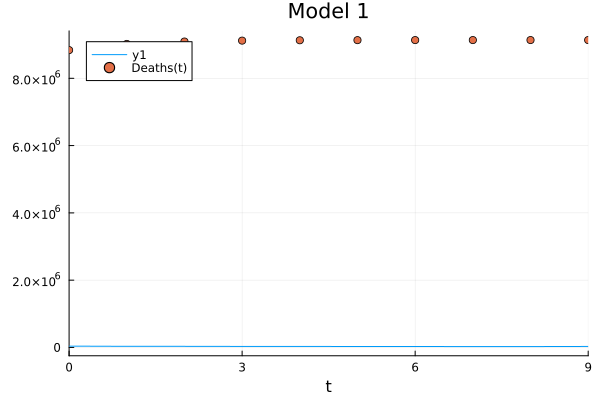

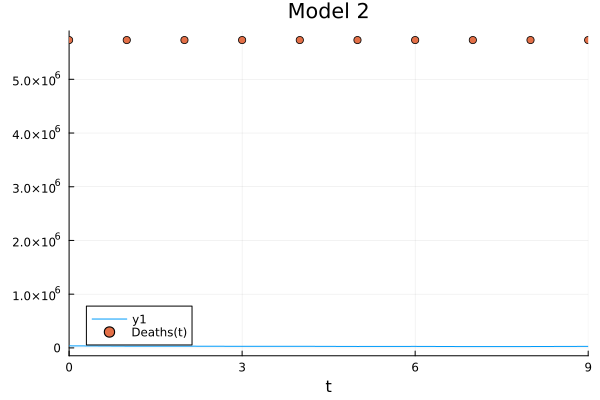

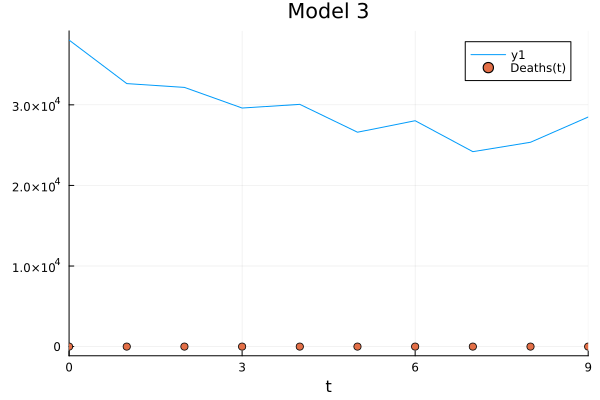

In [29]:
ts = dfi.t
for (i, prob) in enumerate(new_probs)
    sol = solve(prob; saveat = ts)
    plt = plot_covidhub(dfi)

    # todo change the color of the forecasted points to be distinct from data used to calibrate
    scatter!(plt, sol, idxs = [Deaths, Cases, Hospitalizations];title="Model $(i)")
    display(plt)
end

6. Assess consistency of the ensemble by tracking the smoothness/continuity of the ensemble weights across the time periods of interest. (plots from page 1, and bar plot)

In [ ]:
# still todo is the weighted sums for the ensemble and smoothness 


7. Build and run a forecast simulator
    * Select the alignment/map from 
    * Select the ensemble model from 
    * Select the calibrated parameter output from 
    * Select the time points of the forecast horizon 
    * forecast(calibrated 4, df), forecast(4, df, calibrationmap)
    * ensemble_forecast(4, df, map, weights)
